## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code.

#### Import libraries and setup matplotlib

In [35]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from text import text_to_sequence
from audio import init_stft, mel_spectrogram

import warnings
warnings.filterwarnings("ignore")

In [36]:
checkpoint_path = None
text = 'Ma armastan eesti keelt'
voice = '/Users/olehmatsuk/Thesis/data/konekorpus/Birgit_Itse/20051203-0930ER_uudised_2005_12_03_08_30_107.995_110.099_planned_high_studio.wav'

#### Setup hparams

In [37]:
hparams = create_hparams()

#### Load model from checkpoint

In [38]:
model = Tacotron2(hparams)
if checkpoint_path is not None: 
    model.load_state_dict(torch.load(checkpoint_path)['state_dict'])

#### Load WaveGlow for mel2audio synthesis and denoiser

In [39]:
waveglow_path = 'waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
for k in waveglow.convinv:
    k.float()

#### Prepare text input

In [40]:
sequence = torch.tensor(text_to_sequence(text, hparams.text_cleaners), dtype=torch.long)

#### Prepare voice input

In [41]:
stft = init_stft(hparams)

In [42]:
mel_input = mel_spectrogram(voice, stft)

#### Decode text input and plot results

In [43]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

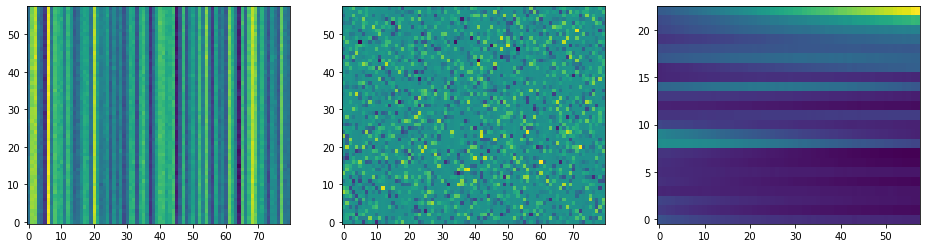

In [45]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference((sequence.unsqueeze(0), mel_input.T.unsqueeze(0)))
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [47]:
with torch.no_grad():
    audio = waveglow.cpu().infer(mel_outputs_postnet.transpose(1, 2), sigma=0.666)
ipd.Audio(audio[0].data.numpy(), rate=hparams.sampling_rate)